In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import warnings
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
import pickle


import datetime
import sys
import os
import openpyxl
import xlrd

In [5]:
# !pip install statsmodels openpyxl xlrd

# Read in the Consolidated Dataset

In [6]:
df = pd.read_csv('Econ_Project_Data_Consolidated.csv')
df["Date"] = pd.to_datetime(df["Date"])

df.head(5)

Date  Average_Hourly_Earning  Trade_Volume_Pct_Change_Index_Value  \
0 2013-01-01                   23.75                             0.004045   
1 2013-02-01                   23.78                            -0.000250   
2 2013-03-01                   23.80                             0.009400   
3 2013-04-01                   23.87                            -0.002476   
4 2013-05-01                   23.89                            -0.003095   

   US_Crude_Oil_Prices_Dollar_Per_Barrel  Federal_Rates_Monthly  \
0                                  95.00                   0.14   
1                                  95.01                   0.15   
2                                  95.54                   0.14   
3                                  94.41                   0.15   
4                                  94.75                   0.11   

   CPI_Value_Inflation  Nominal_Broad_US_Dollar_Index  \
0              230.280                        90.8255   
1              232.166                        91.5509   
2              232.773                        92.4132   
3              232.531                        92.0478   
4              232.945                        92.5290   

   producer_price_index_all_commodities  Adjusted_Closing_Price  \
0                                 202.5                 1498.11   
1                                 204.3                 1514.68   
2                                 204.0                 1569.19   
3                                 203.5                 1597.57   
4                                 204.1                 1630.74   

   US_Export_to_Russia  US_Unemployment_Rate  US_Consumer_Sentiment  \
0           692.919960                   8.0                   73.8   
1          1008.624490                   7.7                   77.6   
2           917.892441                   7.5                   78.6   
3          1087.226442                   7.6                   76.4   
4           781.571515                   7.5                   84.5   

   US_Gasoline_Dollars_Per_Barrel   Price  US_Mean_Monthly_Market_Volatility  \
0                           3.319  30.030                          13.505238   
1                           3.670  30.650                          14.072632   
2                           3.711  31.078                          13.031500   
3                           3.570  31.128                          13.967273   
4                           3.615  31.922                          13.493636   

   Russia_Ukraine_Date_Flag  Covid_Flag  
0                         0           0  
1                         0           0  
2                         0           0  
3                         0           0  
4                         0           0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Date                                   140 non-null    datetime64[ns]
 1   Average_Hourly_Earning                 140 non-null    float64       
 2   Trade_Volume_Pct_Change_Index_Value    140 non-null    float64       
 3   US_Crude_Oil_Prices_Dollar_Per_Barrel  140 non-null    float64       
 4   Federal_Rates_Monthly                  140 non-null    float64       
 5   CPI_Value_Inflation                    140 non-null    float64       
 6   Nominal_Broad_US_Dollar_Index          140 non-null    float64       
 7   producer_price_index_all_commodities   140 non-null    float64       
 8   Adjusted_Closing_Price                 140 non-null    float64       
 9   US_Export_to_Russia                    140 non-null    float64   

In [8]:
df.shape

(140, 17)

In [9]:
variables_to_plot = [
    "Average_Hourly_Earning", "Trade_Volume_Pct_Change_Index_Value",
    "US_Crude_Oil_Prices_Dollar_Per_Barrel", "Federal_Rates_Monthly",
    "CPI_Value_Inflation", "Nominal_Broad_US_Dollar_Index",
    "producer_price_index_all_commodities", "Adjusted_Closing_Price",
    "US_Export_to_Russia", "US_Unemployment_Rate", "US_Consumer_Sentiment",
    "US_Gasoline_Dollars_Per_Barrel", "Price", "US_Mean_Monthly_Market_Volatility"
]

# Time Series Plots

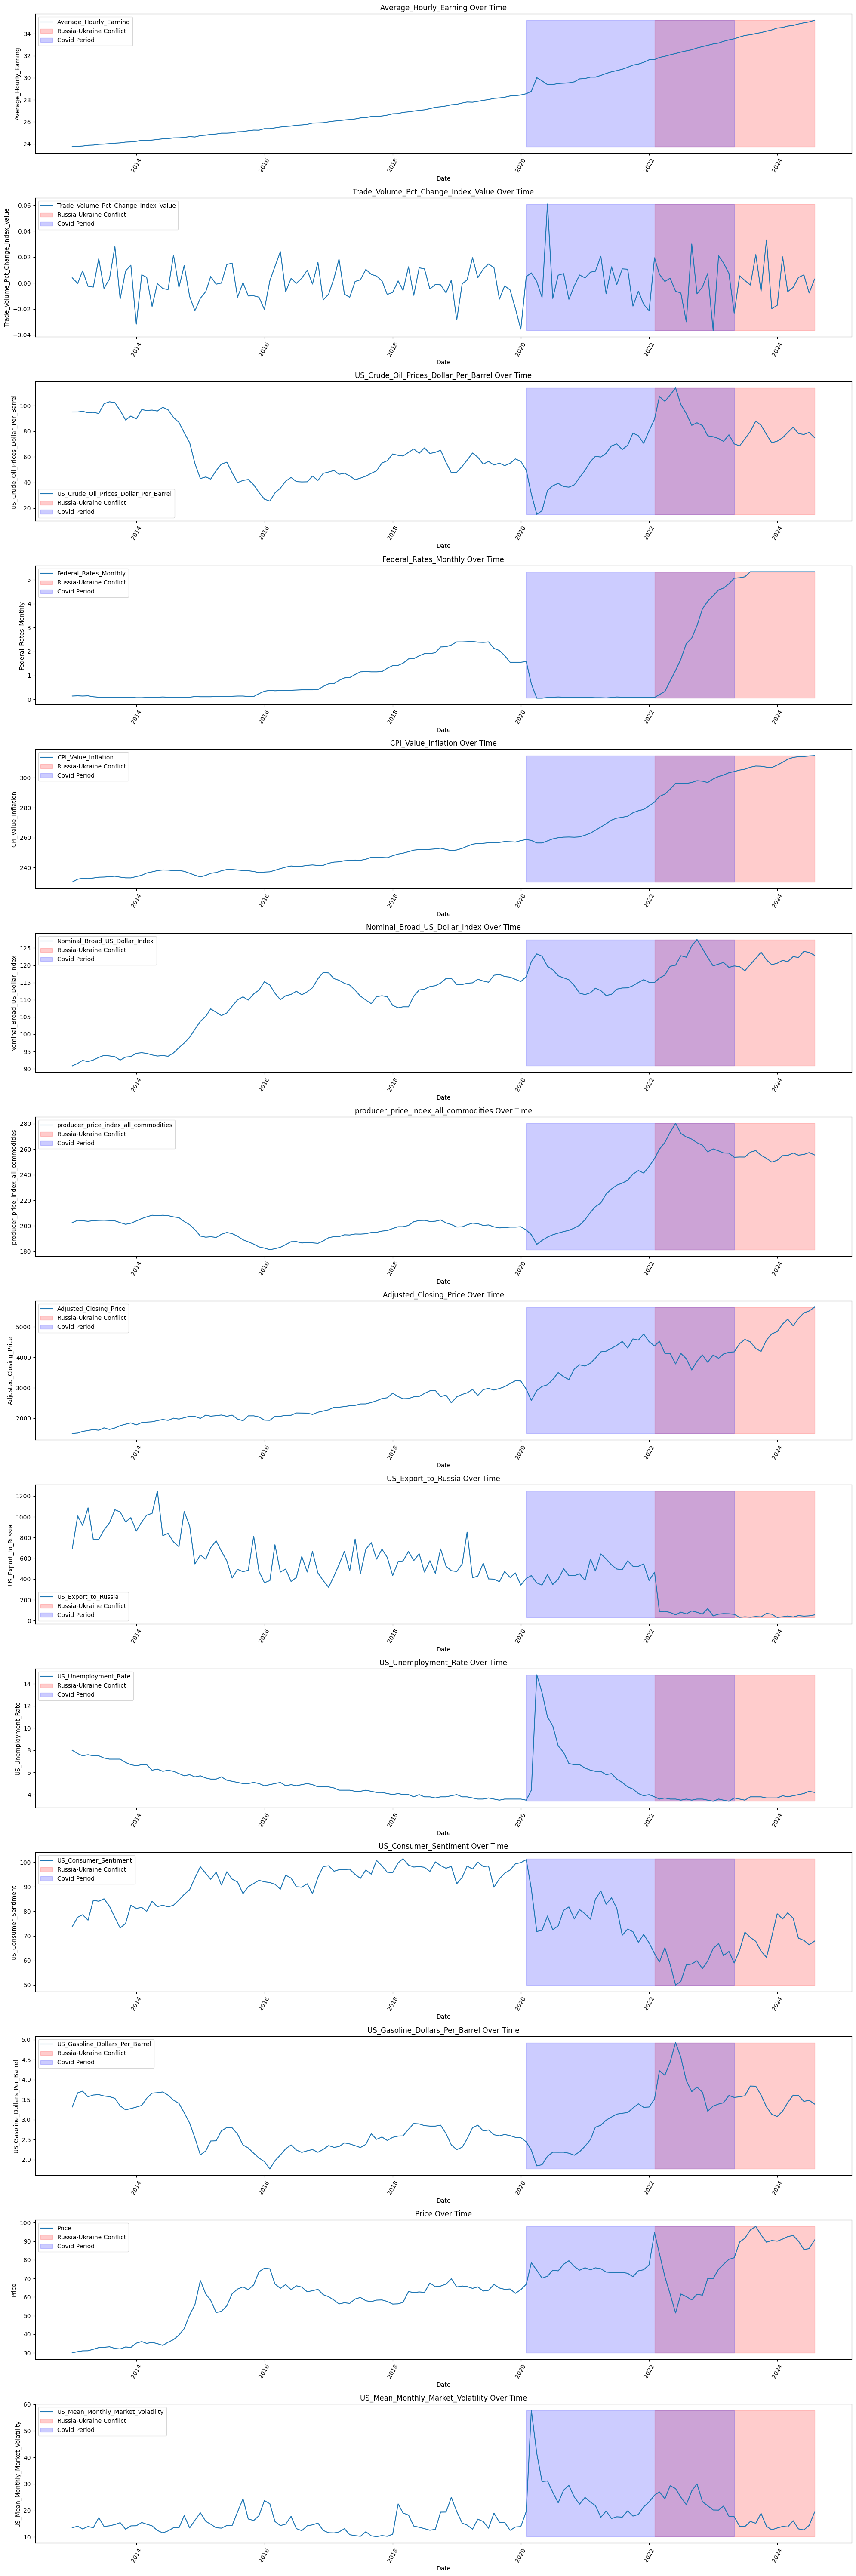

In [11]:
# Plotting each time series on one row using the existing flags for highlighting
plt.figure(figsize=(20,60))

for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(len(variables_to_plot), 1, i)
    plt.plot(df["Date"], df[variable], label=variable)
    
    # Highlighting the Russia-Ukraine conflict period using the existing flag
    plt.fill_between(
        df["Date"], 
        df[variable].min(), df[variable].max(),
        where=(df["Russia_Ukraine_Date_Flag"] == 1), 
        color='red', alpha=0.2, label='Russia-Ukraine Conflict'
    )
    
    # Highlighting the Covid period using the existing flag
    plt.fill_between(
        df["Date"], 
        df[variable].min(), df[variable].max(),
        where=(df["Covid_Flag"] == 1), 
        color='blue', alpha=0.2, label='Covid Period'
    )
    
    plt.title(f'{variable} Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel(variable)
    plt.legend()

plt.tight_layout()
plt.savefig('Graphs/timeseries.png',  dpi=300)
plt.show()

# Pre War and Post War Plots

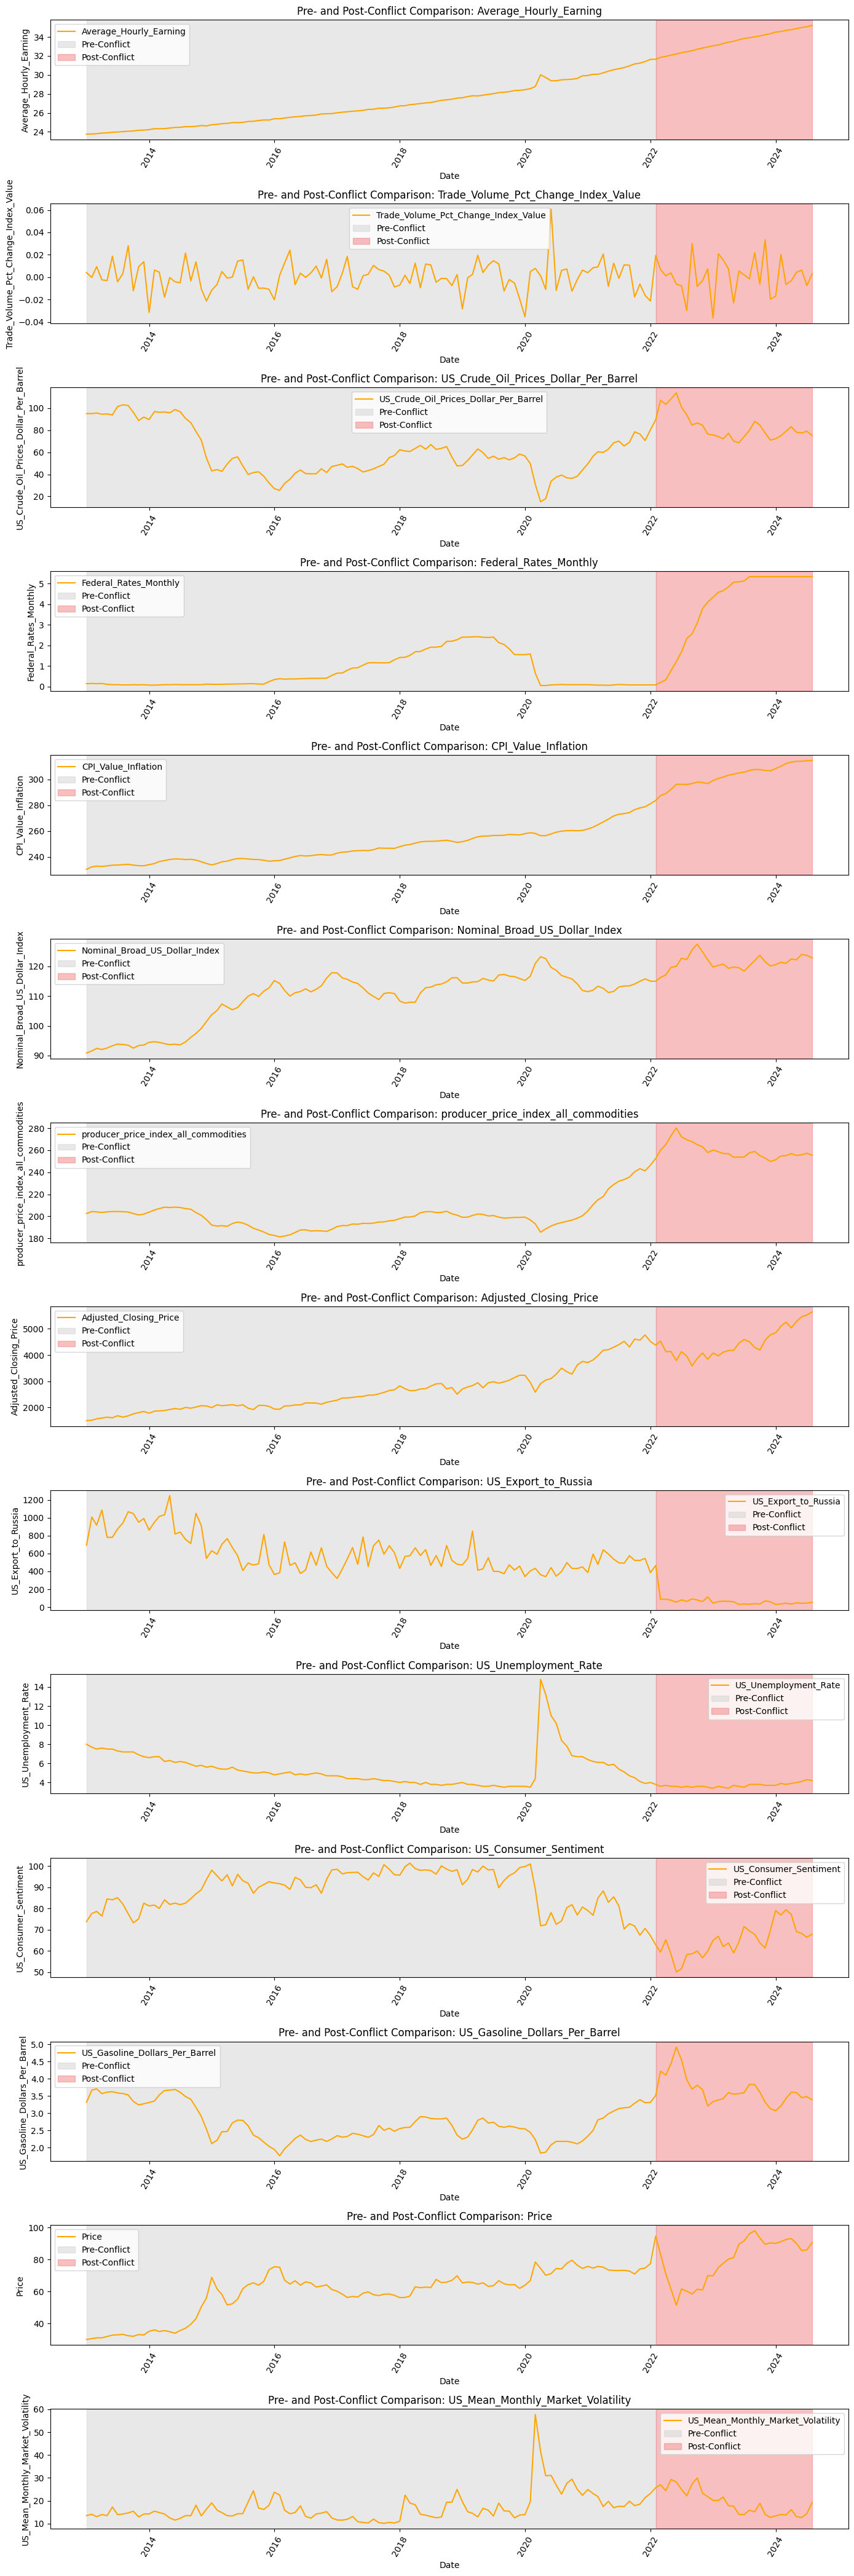

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure that only the desired variables are included, excluding 'Date'
variables_to_plot = [
    "Average_Hourly_Earning", "Trade_Volume_Pct_Change_Index_Value",
    "US_Crude_Oil_Prices_Dollar_Per_Barrel", "Federal_Rates_Monthly",
    "CPI_Value_Inflation", "Nominal_Broad_US_Dollar_Index",
    "producer_price_index_all_commodities", "Adjusted_Closing_Price",
    "US_Export_to_Russia", "US_Unemployment_Rate", "US_Consumer_Sentiment",
    "US_Gasoline_Dollars_Per_Barrel", "Price", "US_Mean_Monthly_Market_Volatility"
]

# Plotting each time series on one row using the existing flags for highlighting
plt.figure(figsize=(14, len(variables_to_plot) * 3))

for i, variable in enumerate(variables_to_plot, 1):
    plt.subplot(len(variables_to_plot), 1, i)
    plt.plot(df["Date"], df[variable], label=variable, color='orange')
    
    # Highlighting pre- and post-conflict periods using the Russia-Ukraine flag
    plt.axvspan(df["Date"].min(), pd.Timestamp('2022-02-01'), color='lightgrey', alpha=0.5, label='Pre-Conflict')
    plt.axvspan(pd.Timestamp('2022-02-01'), df["Date"].max(), color='lightcoral', alpha=0.5, label='Post-Conflict')
    
    plt.title(f'Pre- and Post-Conflict Comparison: {variable}')
    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel(variable)
    plt.legend()

plt.tight_layout()
plt.savefig('Graphs/Timeseries_Plots.png')
plt.show()

# Pairwise Relations

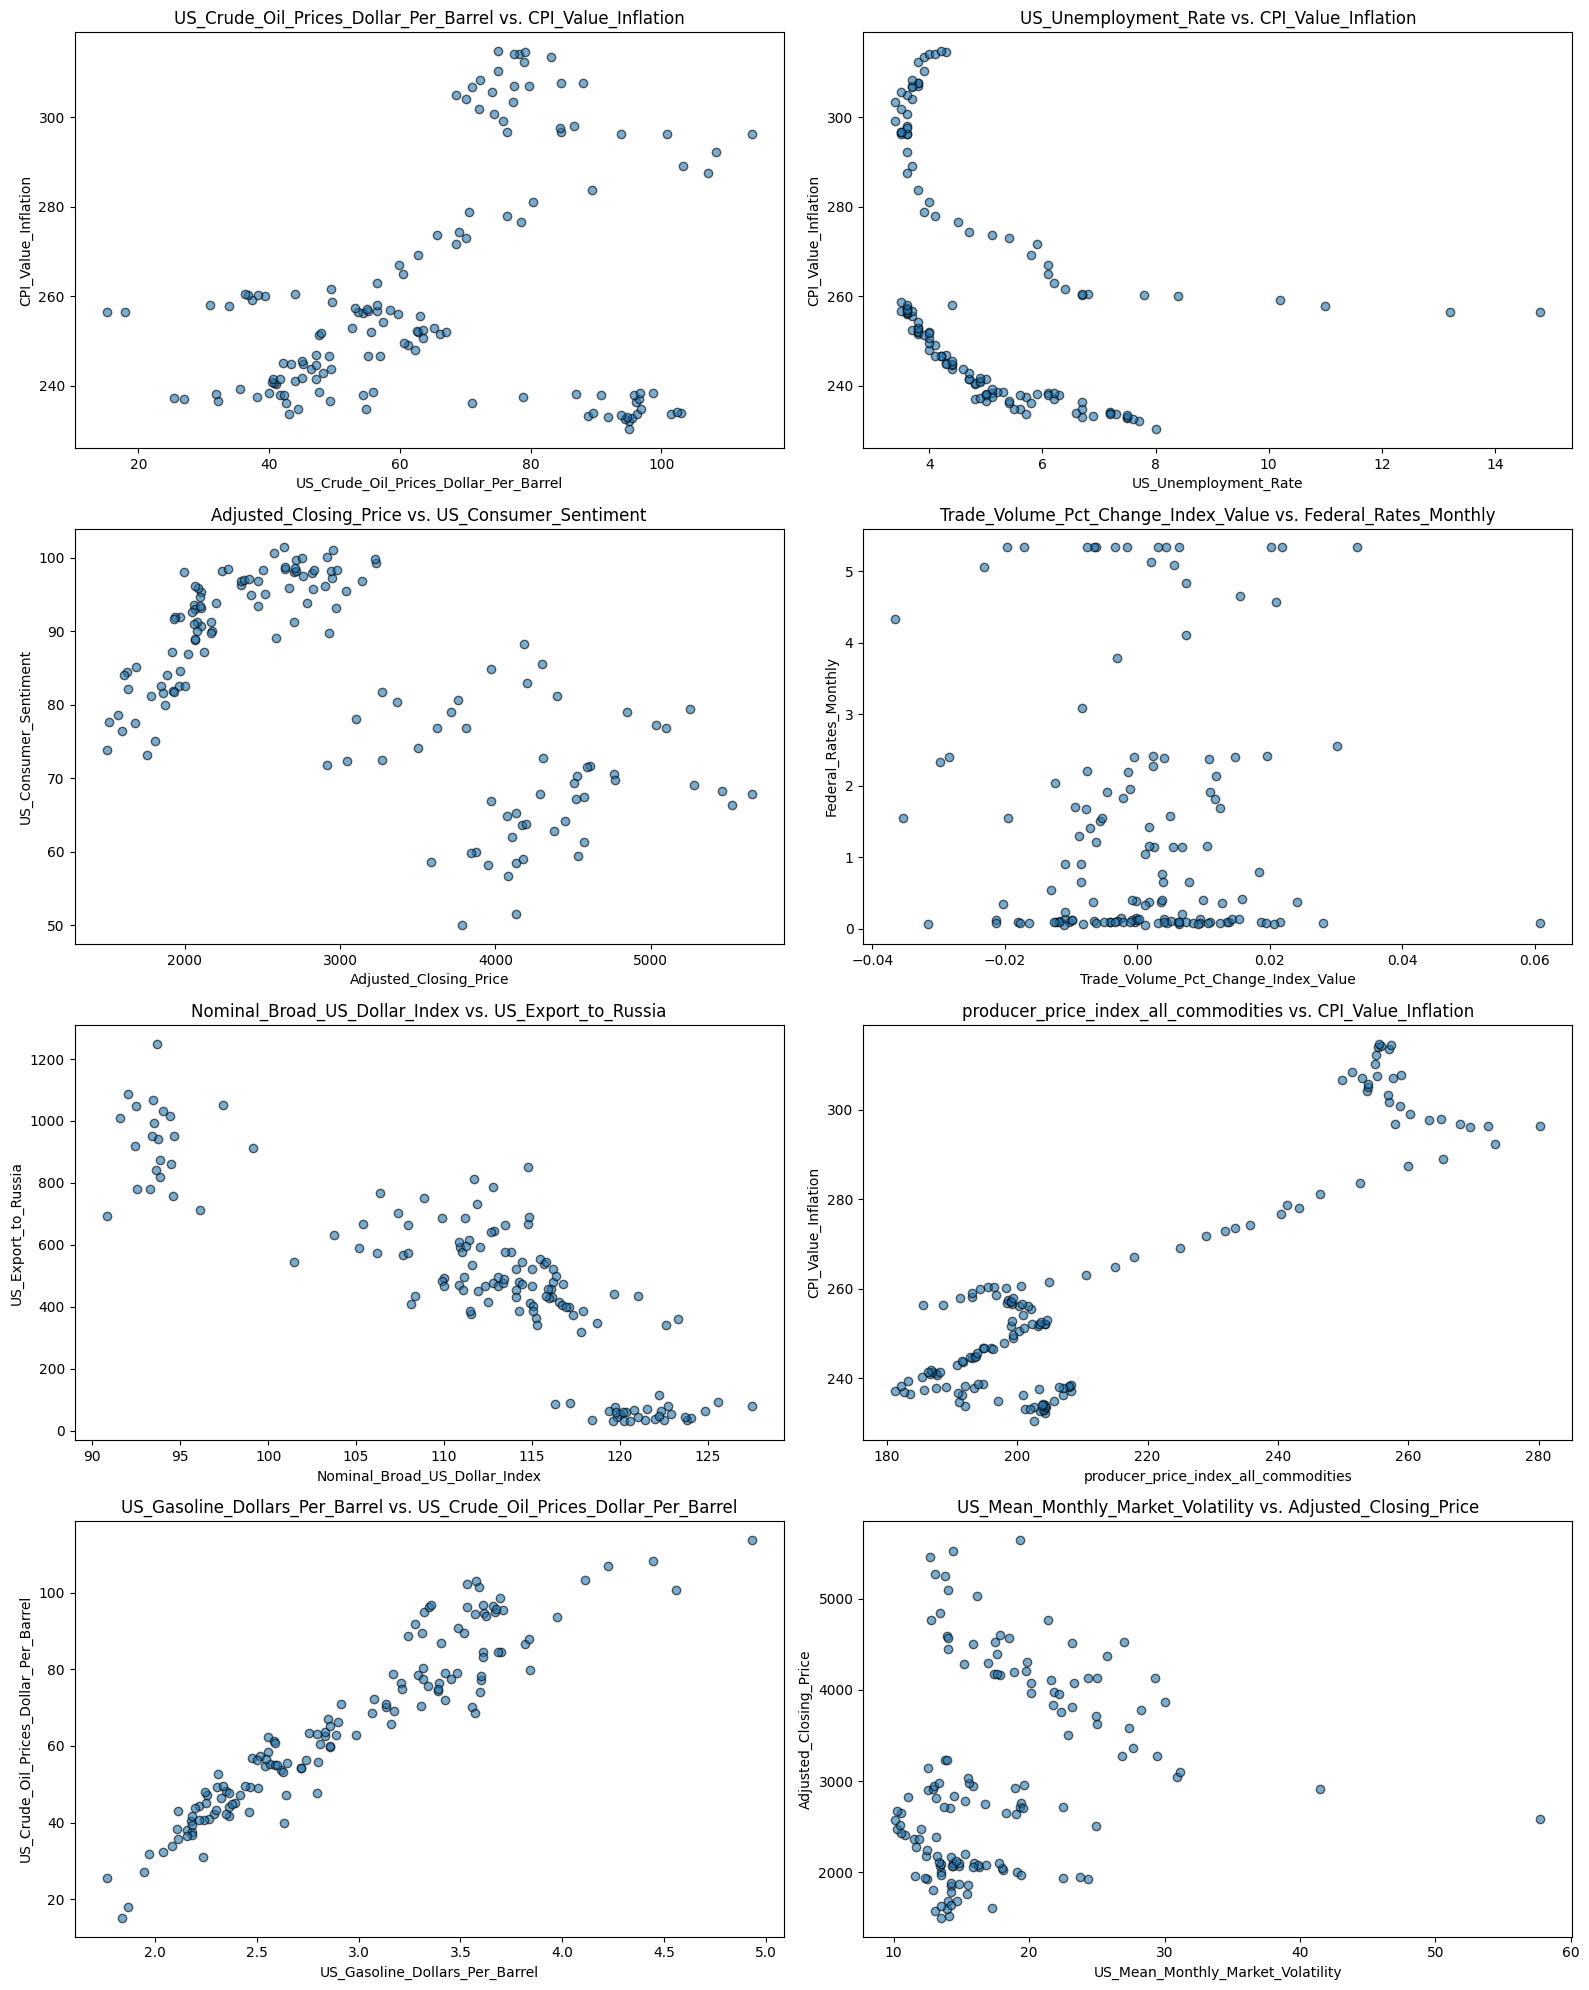

In [14]:
import matplotlib.pyplot as plt

# Expanded list of variable pairs to plot
variable_pairs = [
    ("US_Crude_Oil_Prices_Dollar_Per_Barrel", "CPI_Value_Inflation"),
    ("US_Unemployment_Rate", "CPI_Value_Inflation"),
    ("Adjusted_Closing_Price", "US_Consumer_Sentiment"),
    ("Trade_Volume_Pct_Change_Index_Value", "Federal_Rates_Monthly"),
    ("Nominal_Broad_US_Dollar_Index", "US_Export_to_Russia"),
    ("producer_price_index_all_commodities", "CPI_Value_Inflation"),
    ("US_Gasoline_Dollars_Per_Barrel", "US_Crude_Oil_Prices_Dollar_Per_Barrel"),
    ("US_Mean_Monthly_Market_Volatility", "Adjusted_Closing_Price")
]

# Setting the number of rows and columns for 2 plots per row
num_plots = len(variable_pairs)
num_cols = 2
num_rows = (num_plots // num_cols) + (num_plots % num_cols > 0)

# Plotting scatter plots for all variable pairs
plt.figure(figsize=(16, 20))

for i, (var_x, var_y) in enumerate(variable_pairs, 1):
    plt.subplot(num_rows, num_cols, i)
    plt.scatter(df[var_x], df[var_y], alpha=0.6, edgecolor='k')
    plt.title(f'{var_x} vs. {var_y}')
    plt.xlabel(var_x)
    plt.ylabel(var_y)

plt.tight_layout()
plt.savefig('Graphs/pairwise_plot.png')
plt.show()


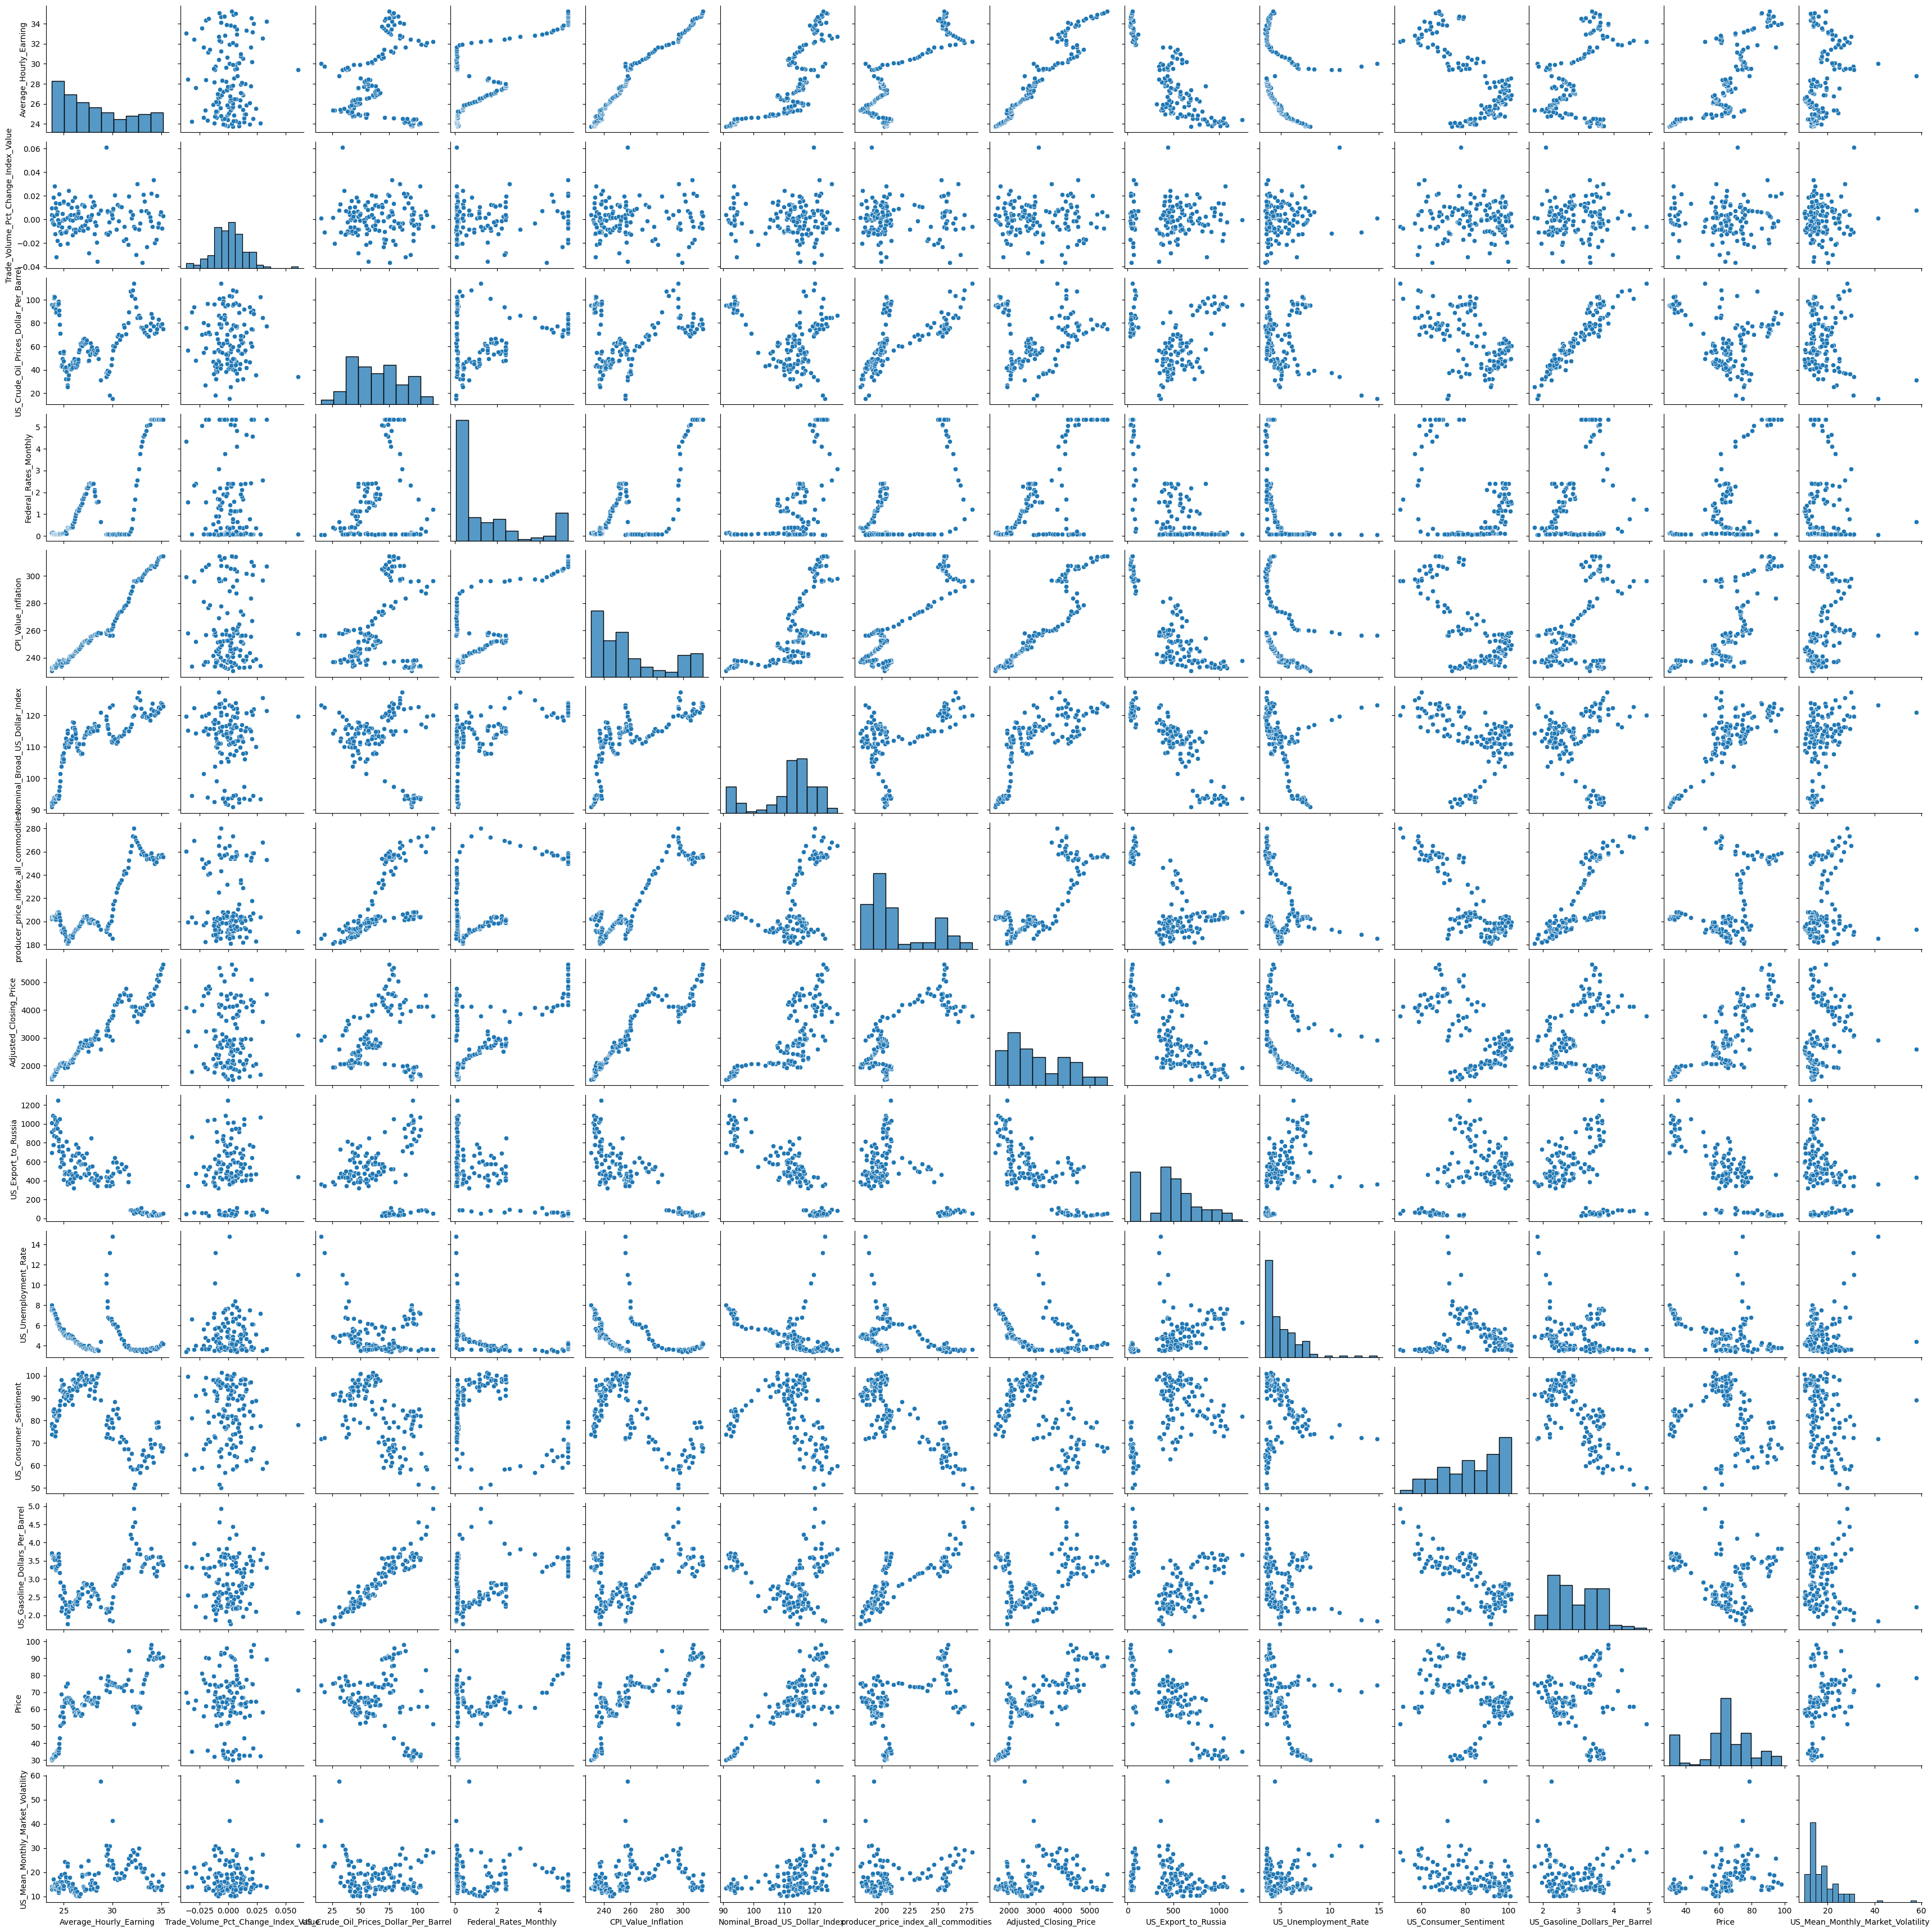

In [15]:
numerical_columns = [
    "Average_Hourly_Earning", "Trade_Volume_Pct_Change_Index_Value",
    "US_Crude_Oil_Prices_Dollar_Per_Barrel", "Federal_Rates_Monthly",
    "CPI_Value_Inflation", "Nominal_Broad_US_Dollar_Index",
    "producer_price_index_all_commodities", "Adjusted_Closing_Price",
    "US_Export_to_Russia", "US_Unemployment_Rate", "US_Consumer_Sentiment",
    "US_Gasoline_Dollars_Per_Barrel", "Price", "US_Mean_Monthly_Market_Volatility"
]

# Creating a pairplot for all numerical variables
sns.pairplot(df[numerical_columns])
plt.savefig("Graphs/CompletePairPlot.png", dpi=500)
plt.show()

# Heatmap

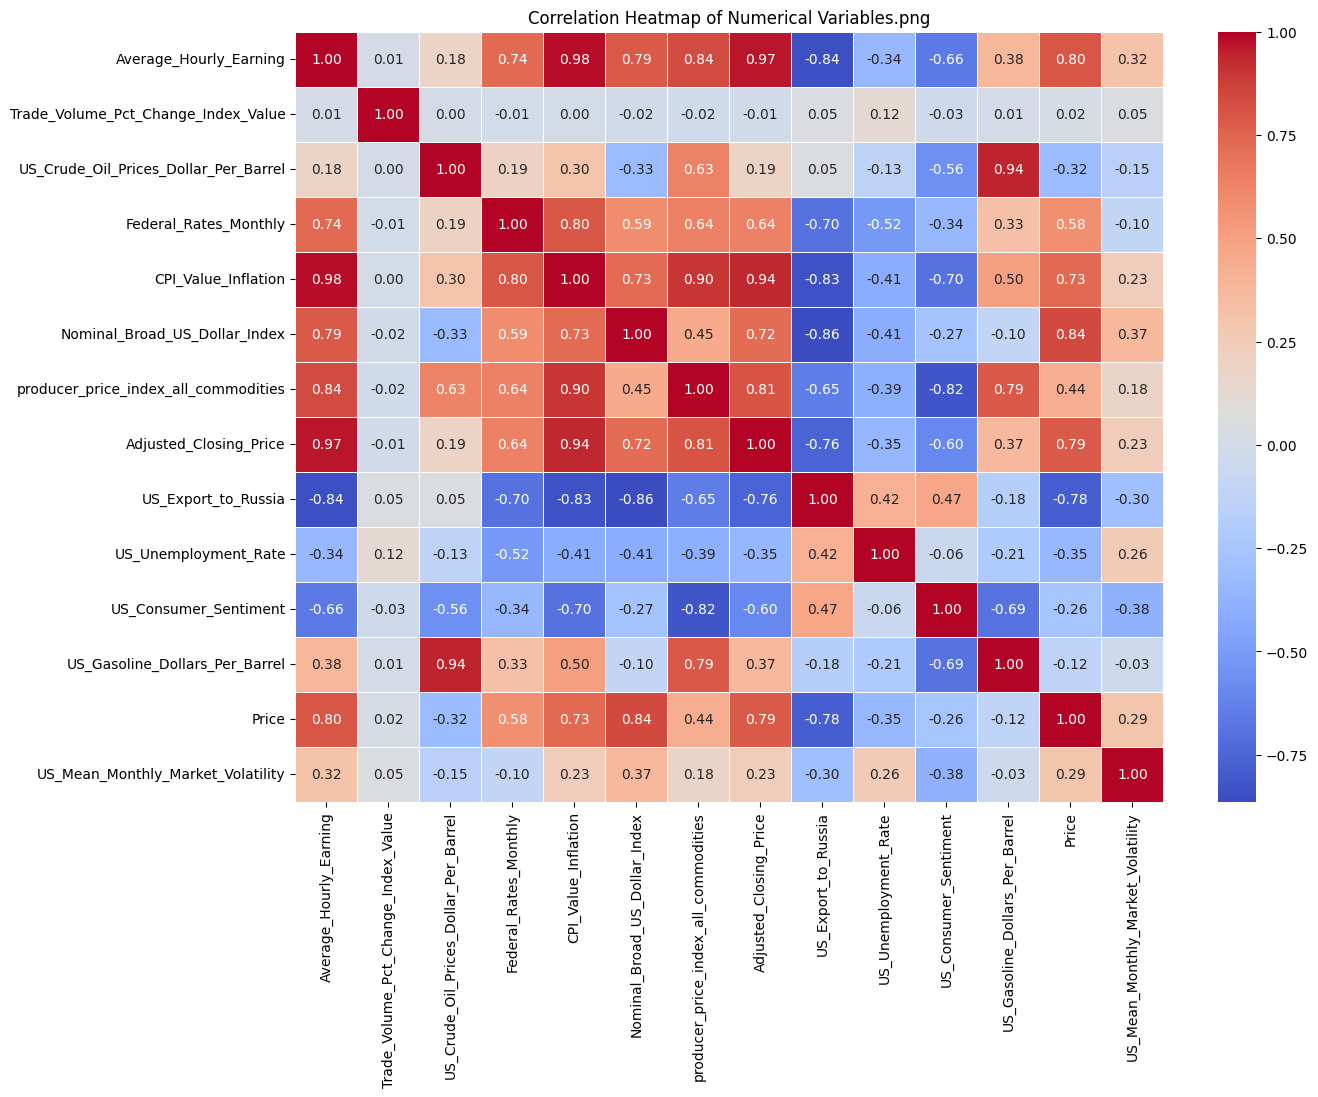

In [16]:
# Calculating the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Plotting the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables.png")
plt.savefig("Graphs/Correlation Heatmap of Numerical Variables.png", dpi=500)
plt.show()

# Histogram and Density Plots

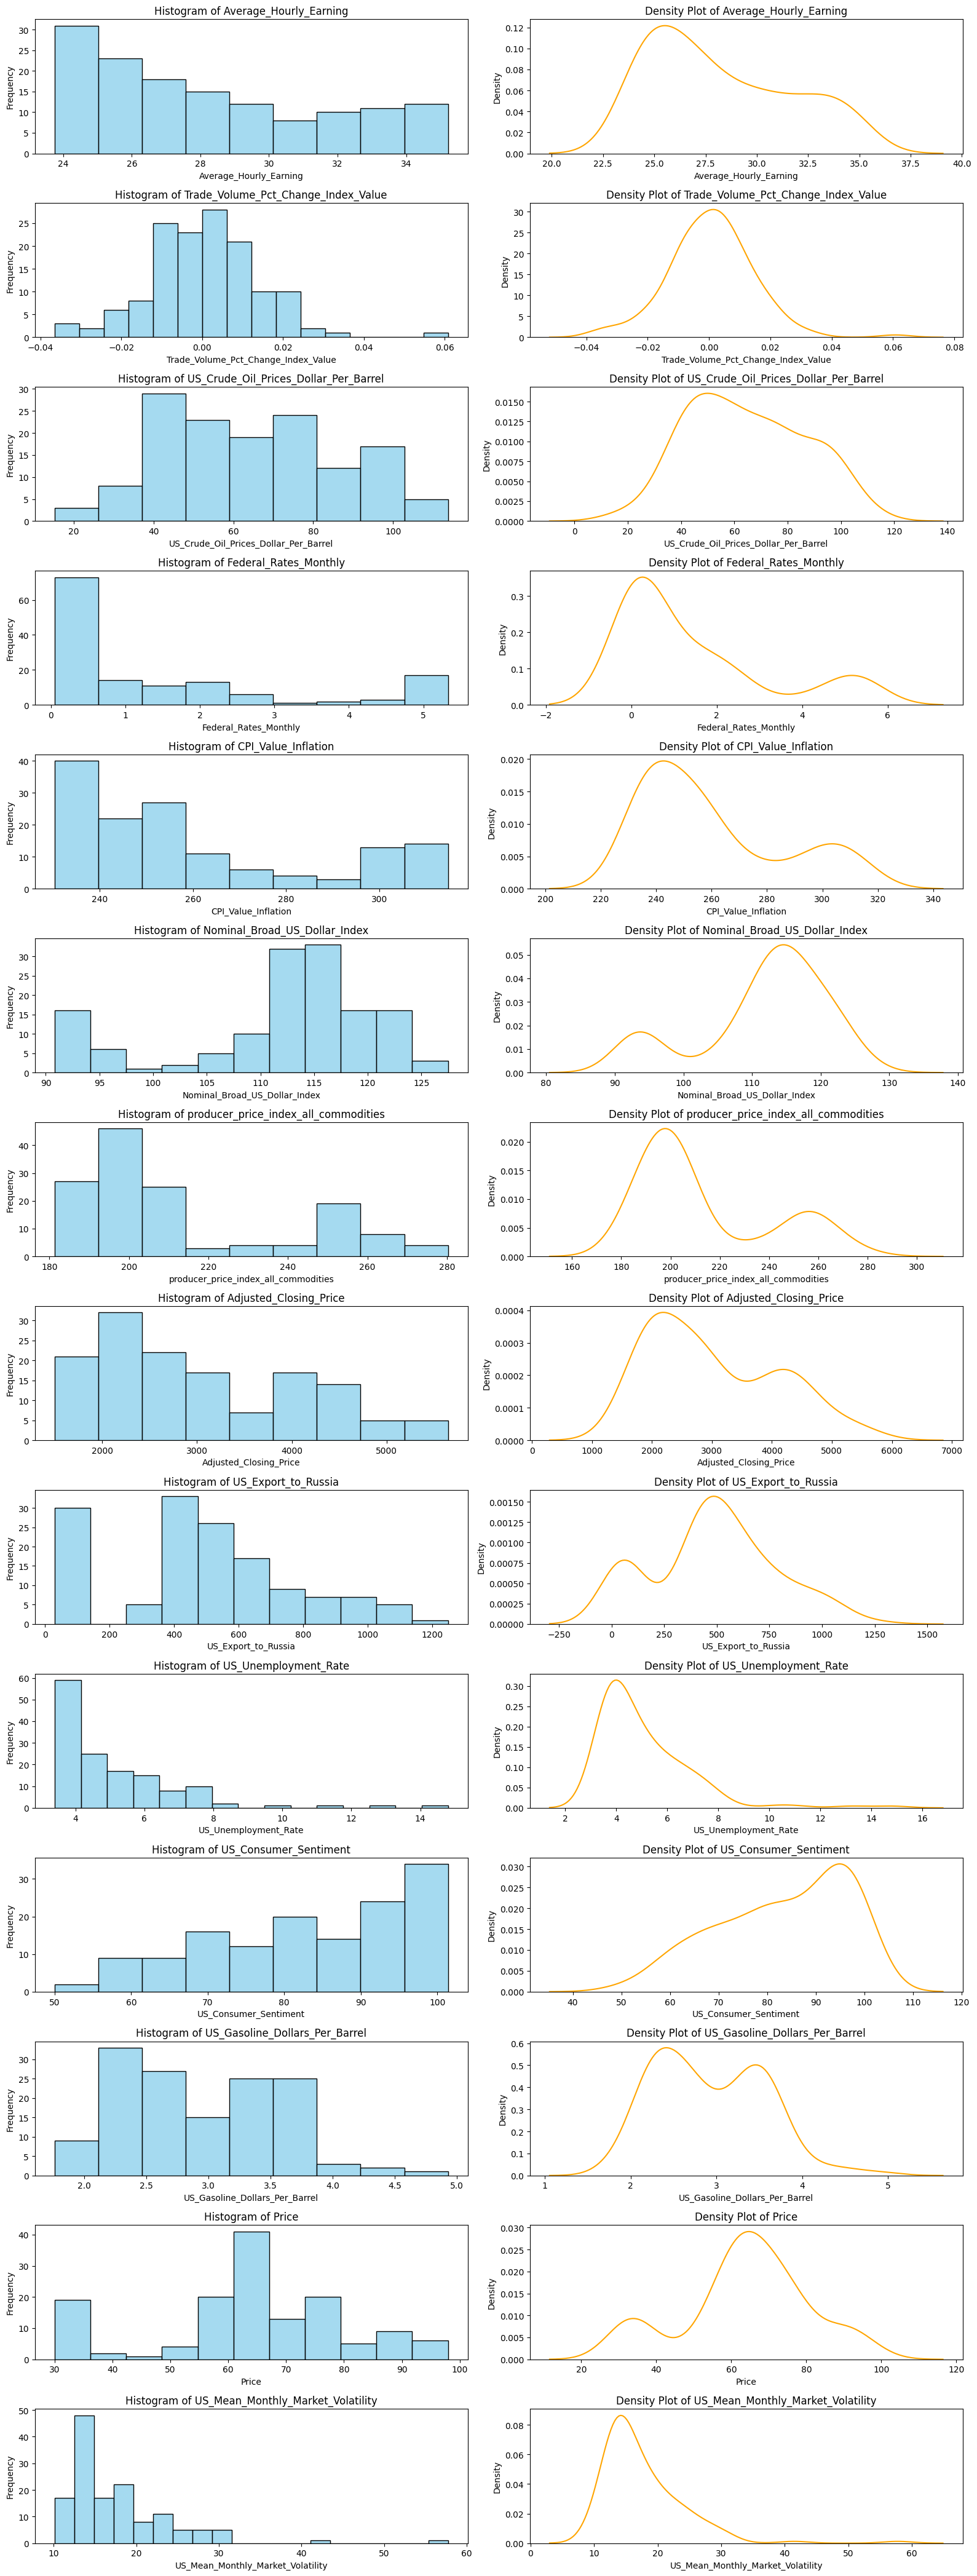

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt



numerical_columns = [
    "Average_Hourly_Earning", "Trade_Volume_Pct_Change_Index_Value",
    "US_Crude_Oil_Prices_Dollar_Per_Barrel", "Federal_Rates_Monthly",
    "CPI_Value_Inflation", "Nominal_Broad_US_Dollar_Index",
    "producer_price_index_all_commodities", "Adjusted_Closing_Price",
    "US_Export_to_Russia", "US_Unemployment_Rate", "US_Consumer_Sentiment",
    "US_Gasoline_Dollars_Per_Barrel", "Price", "US_Mean_Monthly_Market_Volatility"
]


# Plotting histograms and density plots for each variable
plt.figure(figsize=(16, len(numerical_columns) * 3))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, 2 * i - 1)
    sns.histplot(df[column], kde=False, color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    plt.subplot(len(numerical_columns), 2, 2 * i)
    sns.kdeplot(df[column], color='orange')
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.savefig("Graphs/histogram and densitplots.png", dpi=500)
plt.show()


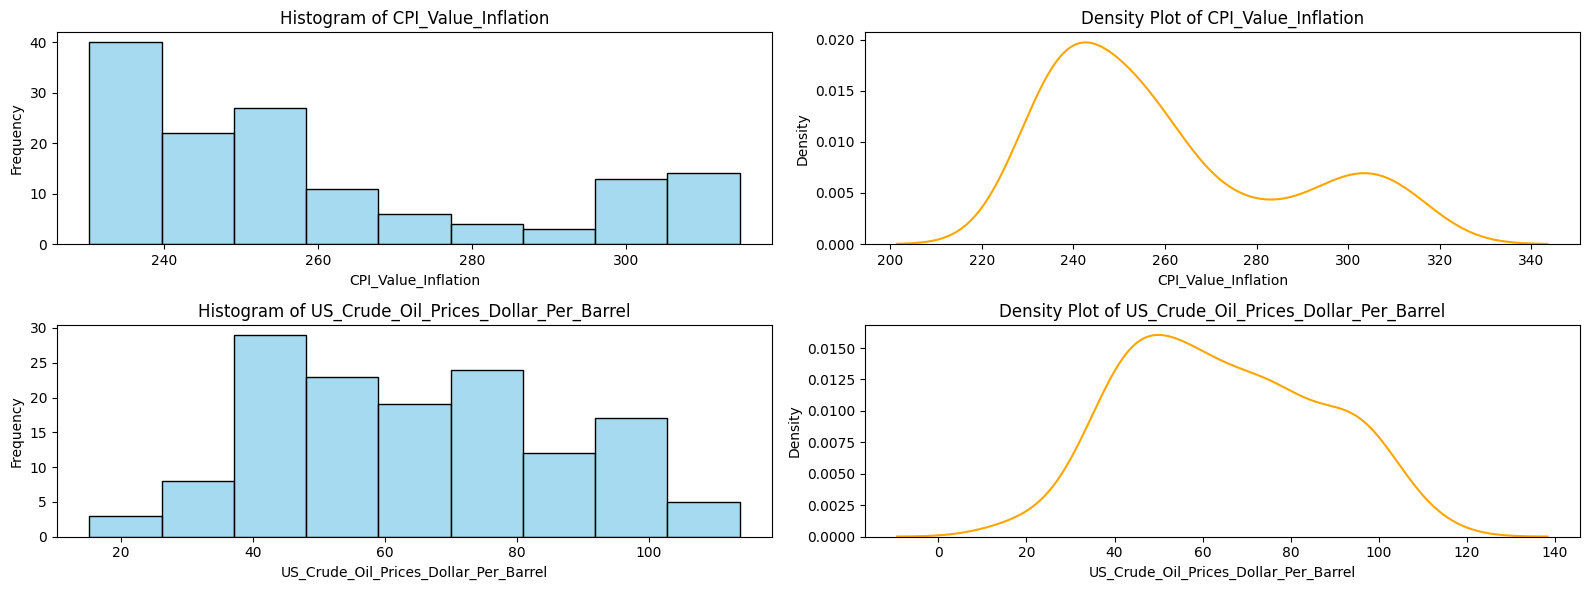

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables of interest
selected_columns = [
    "CPI_Value_Inflation",
    "US_Crude_Oil_Prices_Dollar_Per_Barrel"
]

# Plotting histograms and density plots for the selected variables
plt.figure(figsize=(16, len(selected_columns) * 3))

for i, column in enumerate(selected_columns, 1):
    plt.subplot(len(selected_columns), 2, 2 * i - 1)
    sns.histplot(df[column], kde=False, color='skyblue')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    plt.subplot(len(selected_columns), 2, 2 * i)
    sns.kdeplot(df[column], color='orange')
    plt.title(f'Density Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')

plt.tight_layout()
plt.savefig("Graphs/selected_histogram_and_density_plots.png", dpi=500)
plt.show()


# Box Plots

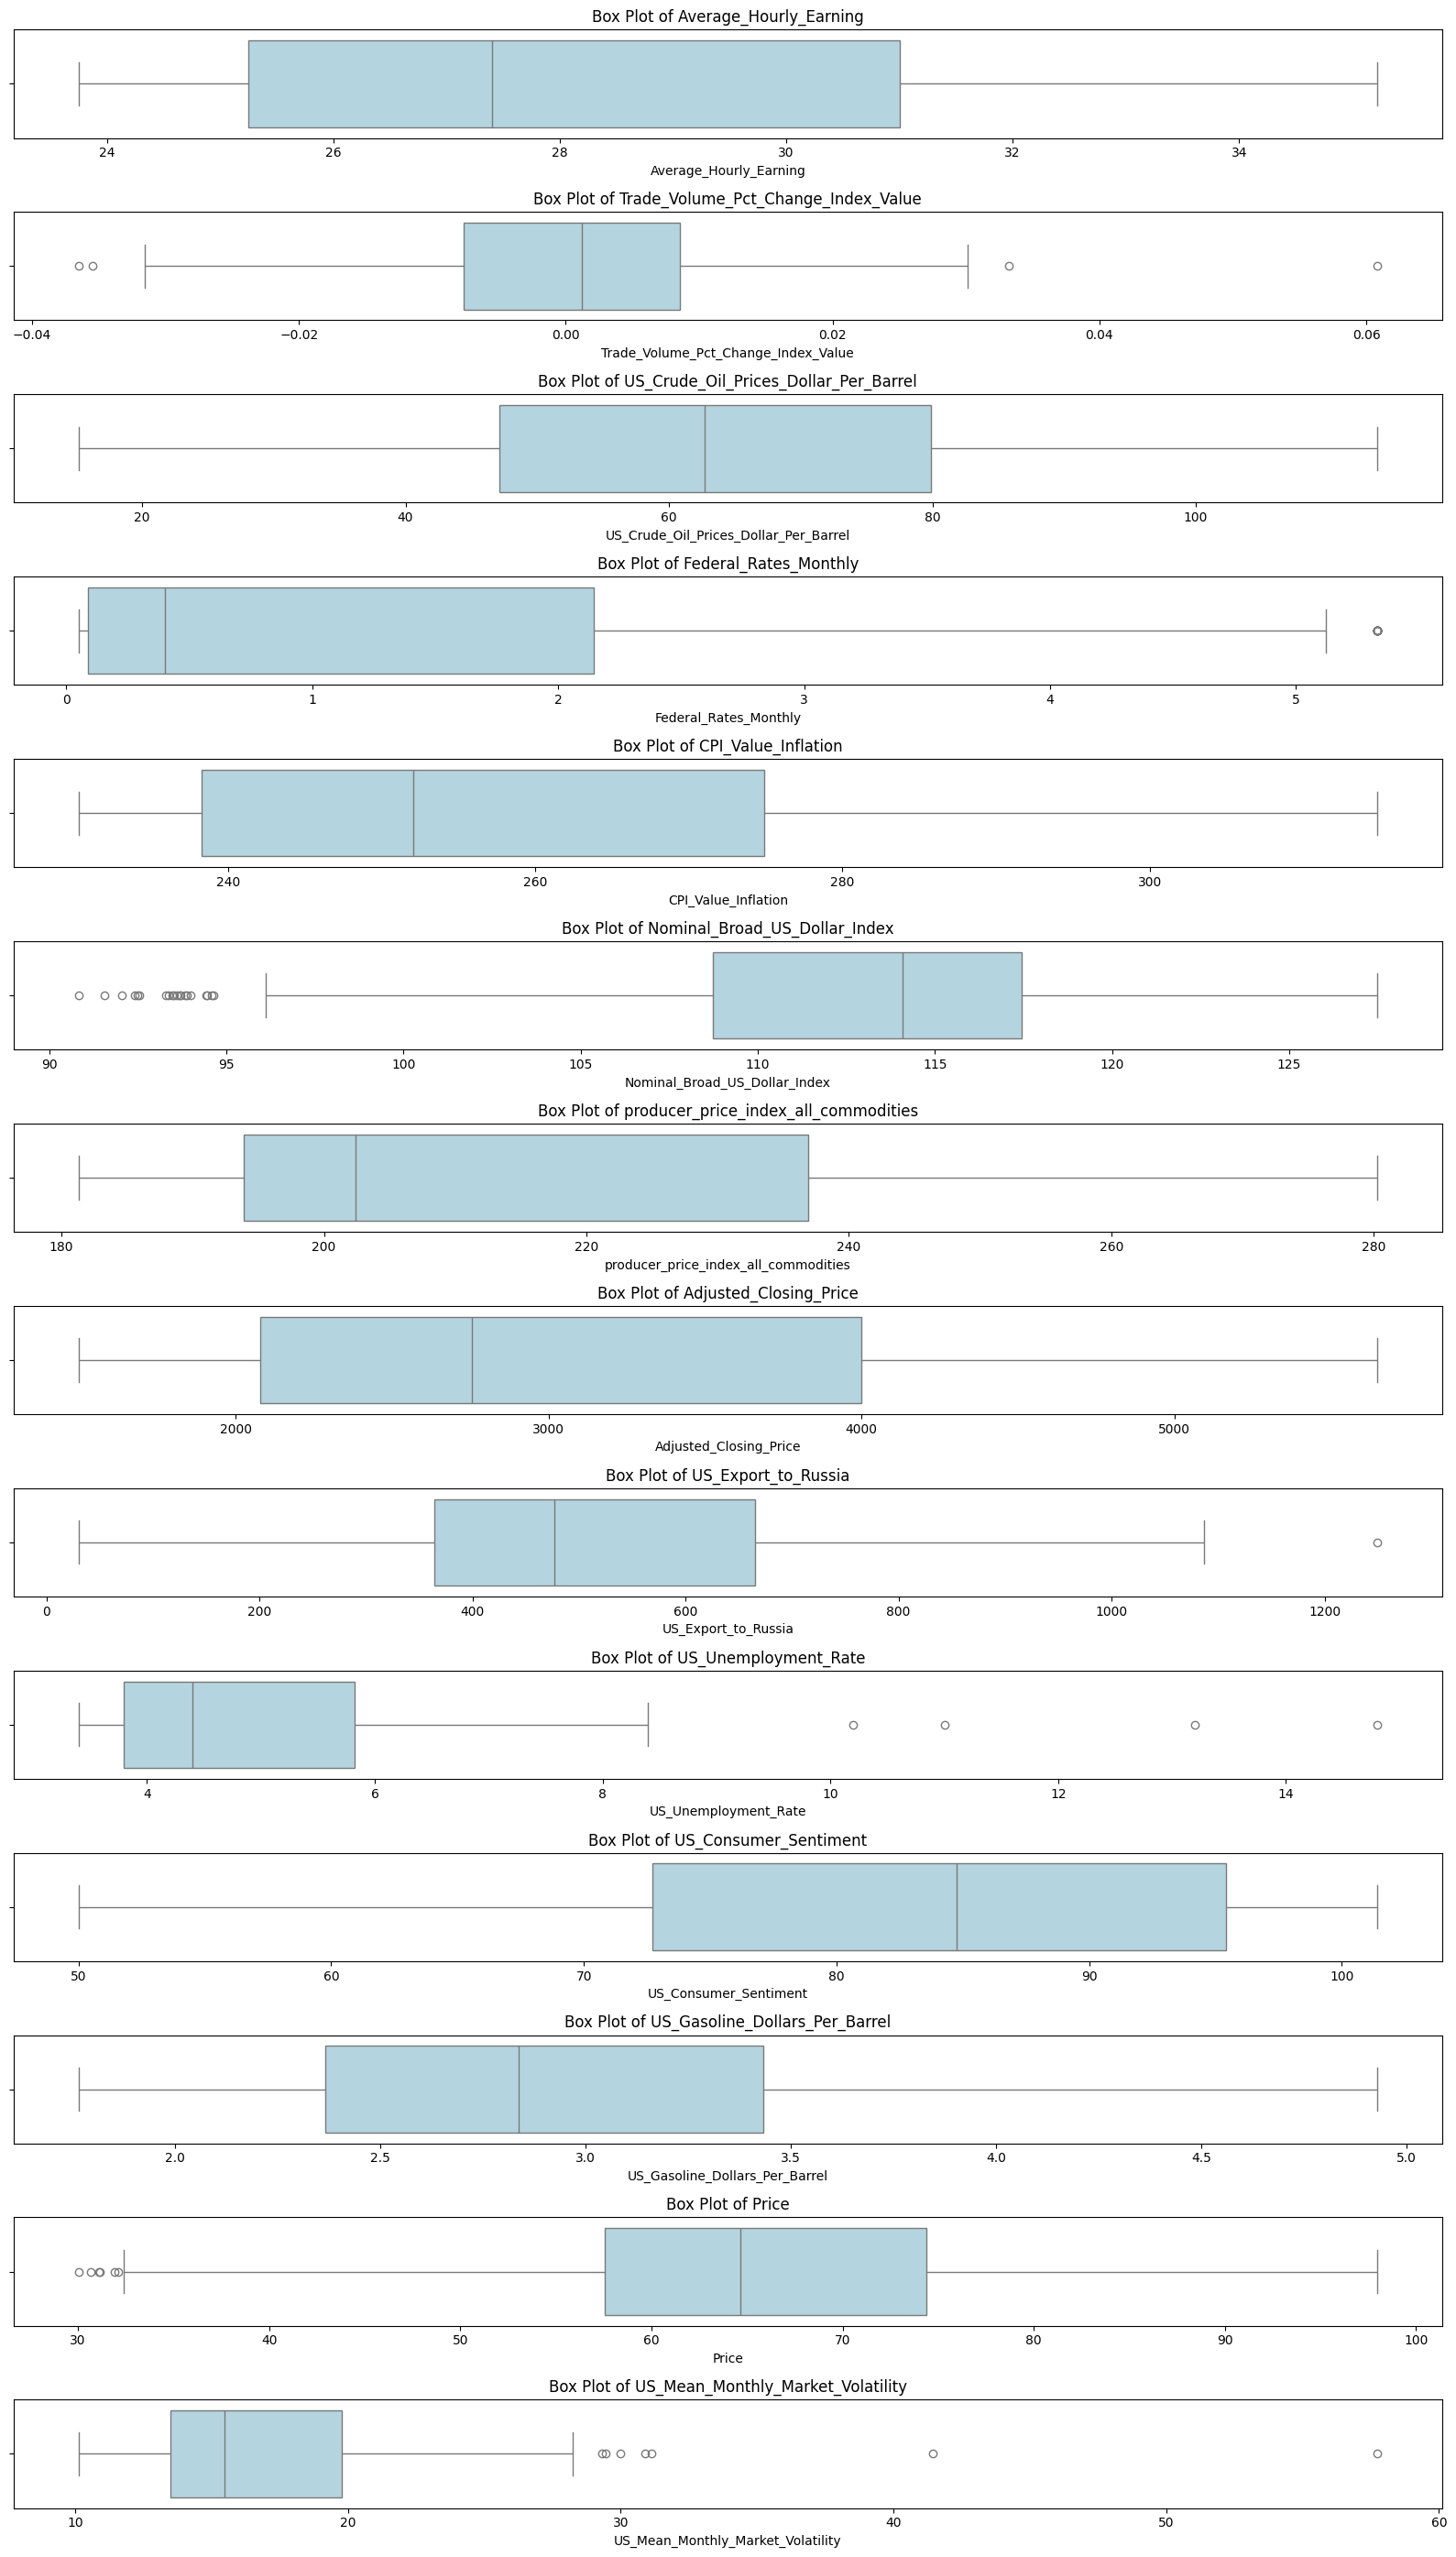

In [19]:
# Plotting box plots for each variable
plt.figure(figsize=(16, len(numerical_columns) * 2))

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, i)
    sns.boxplot(x=df[column], color='lightblue')
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.savefig("Graphs/Boxplot.png", dpi=500)
plt.show()


# Event Study Plot

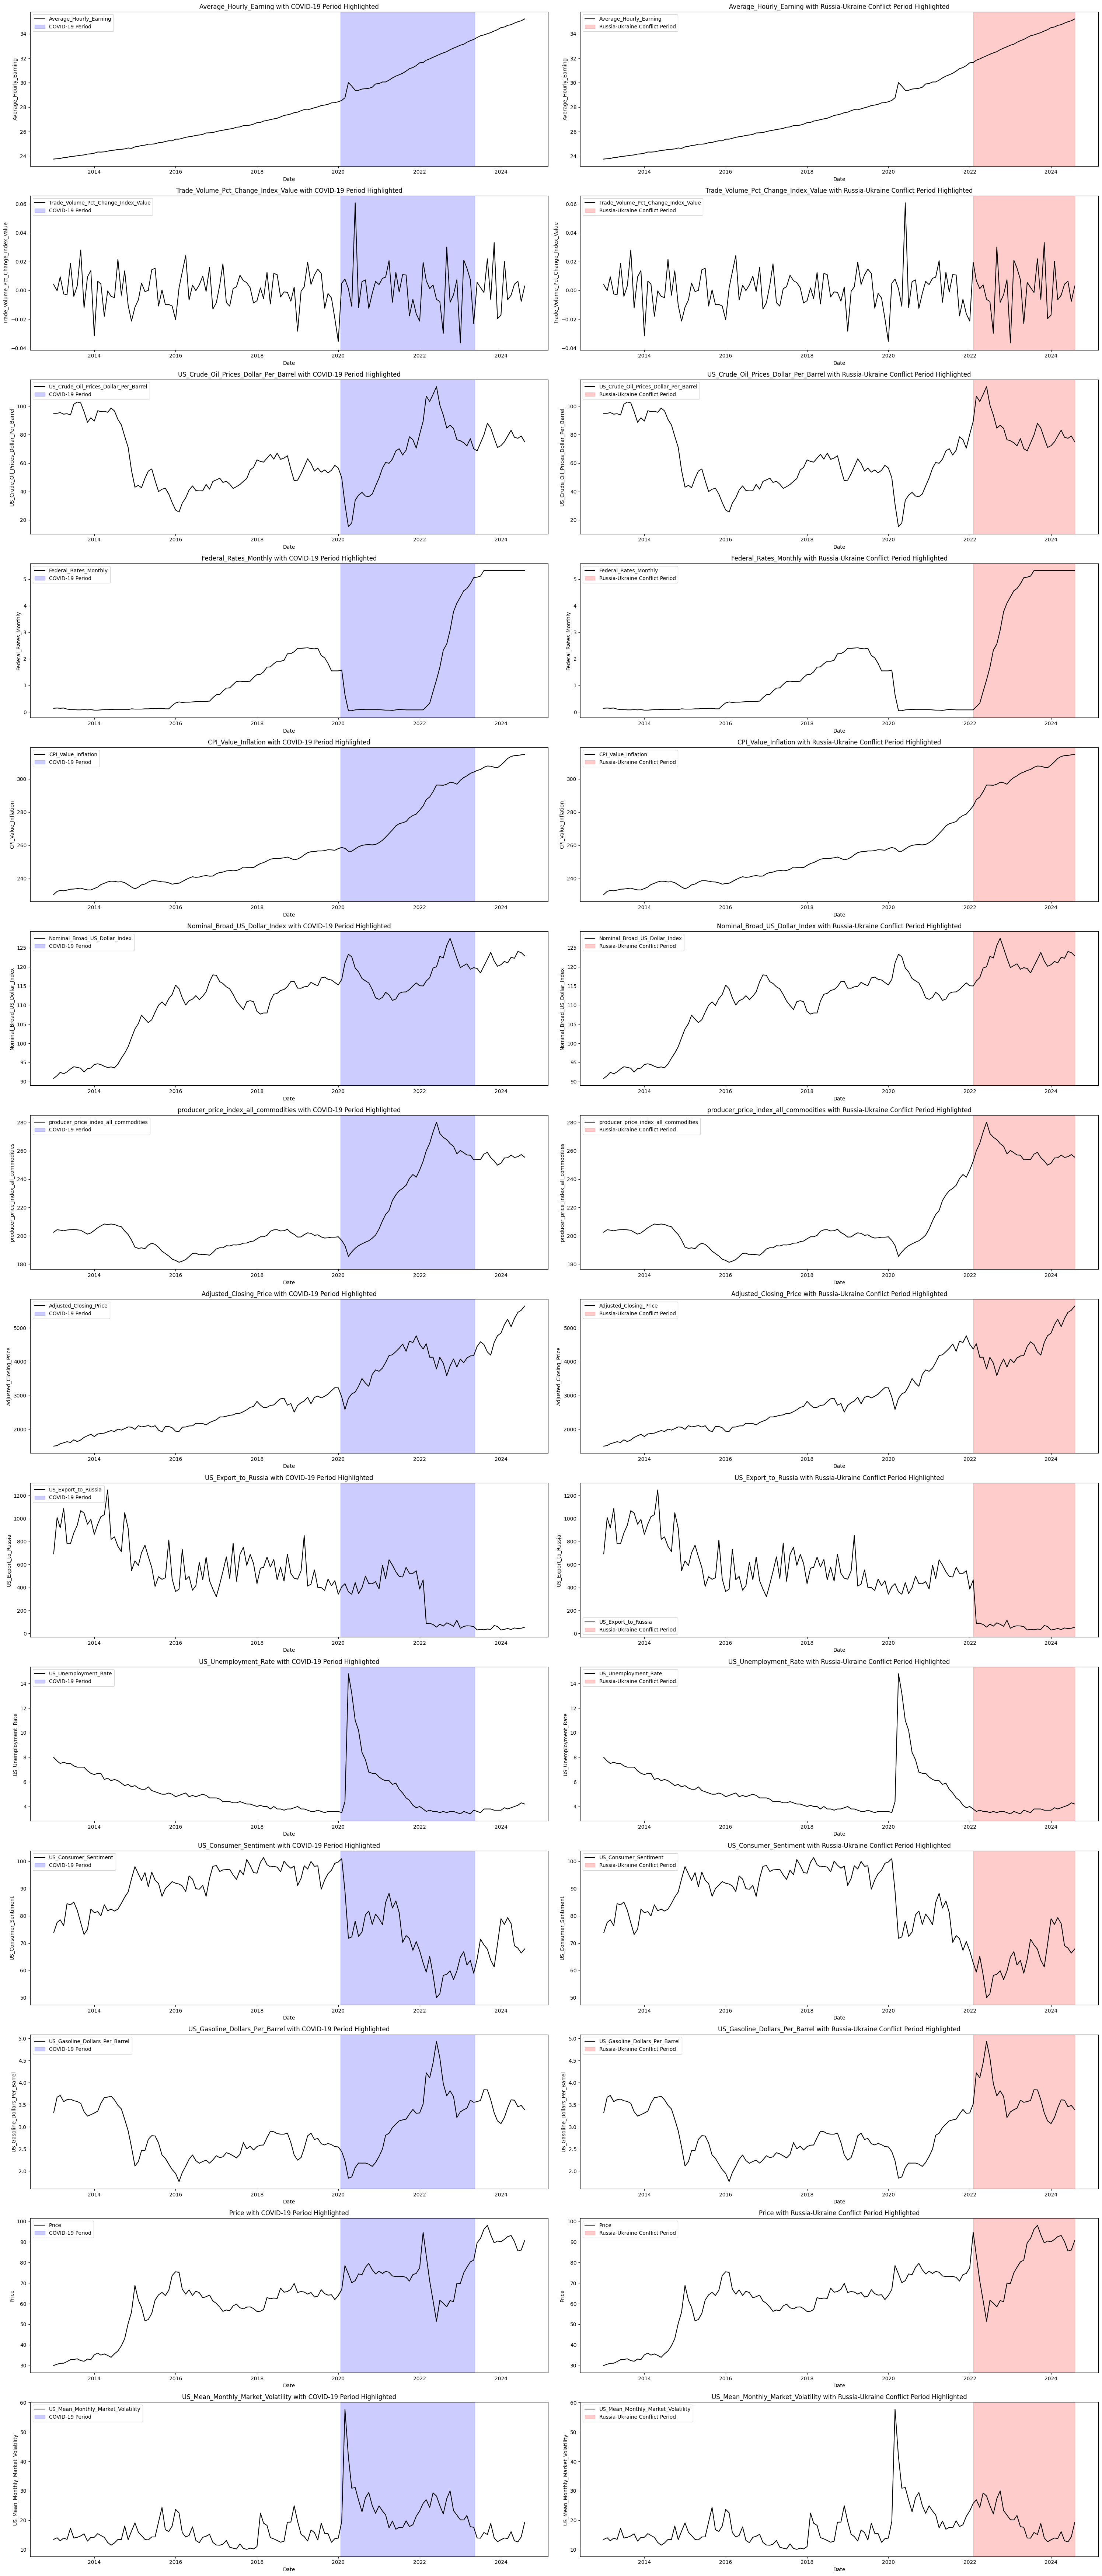

In [22]:
import matplotlib.pyplot as plt

# List of key economic variables for the event study
event_study_variables = numerical_columns

# Defining the event periods
covid_start = pd.Timestamp("2020-01-20")
covid_end = pd.Timestamp("2023-05-11")
conflict_start = pd.Timestamp("2022-02-01")
conflict_end = df["Date"].max()

# Plotting each variable with two plots: one for COVID-19 and one for the Russia-Ukraine conflict
plt.figure(figsize=(30, len(event_study_variables) * 5))

for i, variable in enumerate(event_study_variables):
    # Plot highlighting the COVID-19 period
    plt.subplot(len(event_study_variables), 2, 2 * i + 1)
    plt.plot(df["Date"], df[variable], label=variable, color='black')
    plt.axvspan(covid_start, covid_end, color='blue', alpha=0.2, label='COVID-19 Period')
    plt.title(f'{variable} with COVID-19 Period Highlighted')
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.legend()

    # Plot highlighting the Russia-Ukraine conflict period
    plt.subplot(len(event_study_variables), 2, 2 * i + 2)
    plt.plot(df["Date"], df[variable], label=variable, color='black')
    plt.axvspan(conflict_start, conflict_end, color='red', alpha=0.2, label='Russia-Ukraine Conflict Period')
    plt.title(f'{variable} with Russia-Ukraine Conflict Period Highlighted')
    plt.xlabel('Date')
    plt.ylabel(variable)
    plt.legend()

plt.tight_layout()
plt.savefig("Graphs/Event_Study_Plot.png", dpi=500)
plt.show()

## Correlation Analysis of the Stationary Data

In [23]:
df_stat = pd.read_csv('Econ_Data_Stationary.csv')
df_stat.head()

Unnamed: 0        Date  Russia_Ukraine_Date_Flag  Covid_Flag  \
0           2  2013-03-01                         0           0   
1           3  2013-04-01                         0           0   
2           4  2013-05-01                         0           0   
3           5  2013-06-01                         0           0   
4           6  2013-07-01                         0           0   

   Trade_Volume_Pct_Change_Index_Value  US_Crude_Oil_Prices_Dollar_Per_Barrel  \
0                             0.699054                               0.024242   
1                            -0.860321                              -0.051685   
2                            -0.044844                               0.015551   
3                             1.578865                              -0.042537   
4                            -1.657005                               0.347158   

   Federal_Rates_Monthly  Nominal_Broad_US_Dollar_Index  \
0              -0.005705                       0.093609   
1               0.005705                      -0.039667   
2              -0.022819                       0.052238   
3              -0.011410                       0.081917   
4               0.000000                       0.063919   

   Adjusted_Closing_Price  US_Export_to_Russia  US_Unemployment_Rate  \
0                0.050775            -0.313287             -0.111324   
1                0.026435             0.584690              0.055662   
2                0.030897            -1.055390             -0.055662   
3               -0.022784            -0.000835              0.000000   
4                0.074006             0.321705             -0.111324   

   US_Consumer_Sentiment     Price  US_Mean_Monthly_Market_Volatility  \
0               0.075873  0.025972                          -0.163586   
1              -0.166921  0.003034                           0.147032   
2               0.614573  0.048182                          -0.074419   
3              -0.030349  0.055403                           0.593590   
4               0.075873  0.007585                          -0.518028   

   Average_Hourly_Earning  CPI_Value_Inflation  \
0               -0.002908            -0.049938   
1                0.014539            -0.033149   
2               -0.014539             0.025613   
3                0.014539             0.005661   
4               -0.014539            -0.018234   

   producer_price_index_all_commodities  
0                             -0.077311  
1                             -0.007363  
2                              0.040496  
3                             -0.014726  
4                             -0.003681

In [24]:
# Var model needs the date time as index
# df_stat['Date'] = pd.to_datetime(df_stat['Date'])
# df_stat = df_stat.set_index('Date')

# # Explicitly set the frequency to 'MS' (Monthly Start)
# df_stat = df_stat.asfreq('MS')



# Exclude the exogenous variables 'Russia_Ukraine_Date_Flag' and 'Covid_Flag'
endogenous_variables = df_stat.drop(columns=['Russia_Ukraine_Date_Flag', 'Covid_Flag'])

# Step 2: Calculate the correlation matrix using Pearson, Spearman, or Kendall
# Choose the method: 'pearson', 'spearman', or 'kendall'
correlation_matrix = endogenous_variables.corr(method='pearson')  # You can change 'pearson' to 'spearman' or 'kendall'

# Step 3: Plot the correlation matrix using a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Endogenous Variables (Excluding Exogenous Variables)")
plt.savefig('Graphs/Correlation for Stationary data.png')
plt.show()

ValueError: could not convert string to float: '2013-03-01'